In [249]:
from abc import ABC, abstractmethod

import math

import imageio
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [250]:
class MixtureDist(ABC):
    def __init__(self, pi):
        self.pi = np.array(pi)
        self.K = len(self.pi)

    @abstractmethod
    def sample(self, L):
        pass

    @abstractmethod
    def p_xz(self, x, k):
        pass

    def p_x(self, x):
        return np.sum([self.pi[k] * self.p_xz(x, k) for k in range(self.K)], axis=0)

class GMDist(MixtureDist):
    def __init__(self, pi, mu, sigma2):
        super().__init__(pi)
        self.mu = np.array(mu)
        self.sigma2 = np.array(sigma2)

    @classmethod
    def random(cls, K):
        mu = np.random.normal(size=K)
        sigma2 = np.exp(np.random.normal(size=K) - 1)
        pi = np.random.dirichlet(5 * np.ones(K))
        return cls(pi, mu, sigma2)

    def sample(self, L):
        choices = np.random.choice(np.arange(self.K), size=L, p=self.pi)
        return np.random.normal(self.mu[choices], np.sqrt(self.sigma2[choices]))

    @staticmethod
    def normal_pdf(x, mu, sigma2):
        return np.exp(-0.5 * (x - mu) ** 2 / sigma2) / np.sqrt(2 * np.pi * sigma2)

    def p_xz(self, x, k):
        return self.normal_pdf(x, self.mu[k], self.sigma2[k])

class UMDist(MixtureDist):
    def __init__(self, pi, a, b):
        super().__init__(pi)
        self.a = np.array(a)
        self.b = np.array(b)

    @classmethod
    def random(cls, K):
        a = np.random.uniform(-1, 3, size=K)
        b = np.random.uniform(3, 5, size=K)
        pi = np.random.dirichlet(5 * np.ones(K))
        return cls(pi, a, b)

    def sample(self, L):
        choices = np.random.choice(np.arange(self.K), size=L, p=self.pi)
        return np.random.uniform(self.a[choices], self.b[choices])

    @staticmethod
    def uniform_pdf(x, a, b):
        return (x >= a) * (x <= b) / (b - a)

    def p_xz(self, x, k):
        return self.uniform_pdf(x, self.a[k], self.b[k])

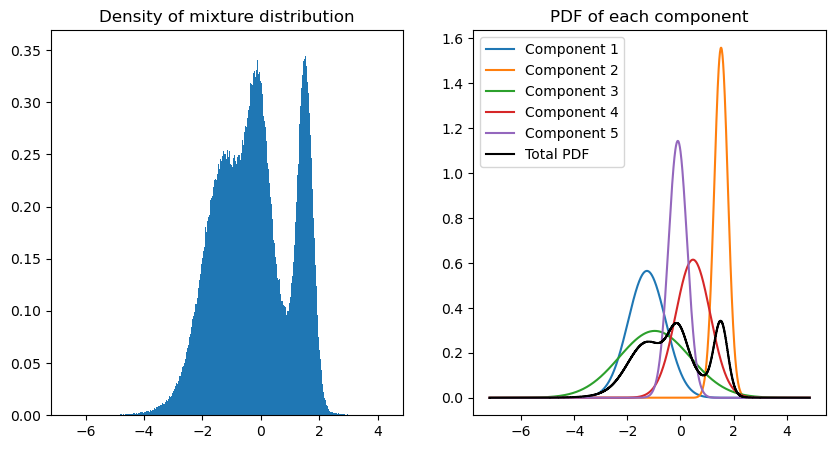

In [251]:
np.random.seed(30)
K = 5
L = 1_000_000
dist = GMDist.random(K)
# dist = UMDist.random(K)
X = dist.sample(L)
linsp = np.linspace(X.min(), X.max(), 1000)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(X, bins=1000, density=True)
axs[0].set_xlim(X.min(), X.max())
axs[0].set_title("Density of mixture distribution")

for i in range(K):
    component = dist.p_xz(linsp, i)
    axs[1].plot(linsp, component, label=f"Component {i + 1}")

total_pdf = dist.p_x(linsp)
axs[1].plot(linsp, total_pdf, label="Total PDF", drawstyle="steps", color="black")
axs[1].legend()
axs[1].set_title("PDF of each component")
plt.show()

In [252]:
class GMM1d:
    def __init__(self, K):
        self.K = K
        self.pi = np.ones(K) / K
        self.mu = np.random.randn(K)
        self.sigma2 = np.ones(self.K)

    def init_from_samples(self, x):
        x = x.reshape(-1)
        indices = np.random.choice(len(x), size=self.K, replace=False)
        self.mu = x[indices]
        
    def e_step(self, x):
        if x.ndim == 1:
            x = x[:, np.newaxis]
        weighted_pdfs = self.pi * norm.pdf(x, loc=self.mu, scale=np.sqrt(self.sigma2))
        gamma = weighted_pdfs / np.sum(weighted_pdfs, axis=1, keepdims=True)
        return gamma

    def m_step(self, x, gamma):
        if x.ndim == 1:
            x = x[:, np.newaxis]
        Nk = np.sum(gamma, axis=0)
        self.pi = Nk / len(x)
        self.mu = np.sum(gamma * x, axis=0) / Nk
        self.sigma2 = np.sum(gamma * (x - self.mu)**2, axis=0) / Nk
        self.sigma2 = np.maximum(self.sigma2, 1e-6)
    
    def log_likelihood(self, x):
        N = x.shape[0]
        weighted_pdfs = self.pi * norm.pdf(x.reshape(-1, 1), loc=self.mu, scale=np.sqrt(self.sigma2))
        total_prob = np.sum(weighted_pdfs, axis=1)
        log_total_prob = np.log(total_prob + 1e-10)
        log_likelihood = np.sum(log_total_prob)
        return log_likelihood / N

    def p_xz(self, x, k):
        if x.ndim == 1:
            x = x[:, np.newaxis]
        return norm.pdf(x, loc=self.mu[k], scale=np.sqrt(self.sigma2[k]))
        
    def p_x(self, x):
        if x.ndim == 1:
            x = x[:, np.newaxis]
        weighted_pdfs = self.pi * norm.pdf(x, loc=self.mu, scale=np.sqrt(self.sigma2))
        return np.sum(weighted_pdfs, axis=1) 

In [247]:
np.random.seed(0)
gmm = GMM1d(K)
num_iterations = 200
gmm.init_from_samples(X)
# gif_duration = 50 # seconds
# duration_per_frame = gif_duration / num_iterations

In [248]:
# frames = []
for i in range(num_iterations):
    gamma = gmm.e_step(X)
    gmm.m_step(X, gamma)
    
    ll = gmm.log_likelihood(X)
    print(f"Epoch: {i}, LL: {ll:.3f}")
    
    # fig, ax = plt.subplots(figsize=(8, 6))
    # ax.plot(linsp, dist.p_x(linsp), label="True PDF", color="blue")
    # ax.plot(linsp, gmm.p_x(linsp), label="Estimated PDF", color="red")
    # ax.hist(X, bins=1000, density=True, alpha=0.5, label="Data", color="gray")
    # ax.set_title(f"Iteration {i+1} - Log-Likelihood: {ll:.3f}")
    # ax.legend()
    # ax.set_xlabel("x")
    # ax.set_ylabel("Density")
    
    # buf = BytesIO()
    # plt.savefig(buf, format="png")
    # buf.seek(0)
    # frames.append(imageio.imread(buf))
    # buf.close()
    # plt.close(fig)

UnboundLocalError: cannot access local variable 'gamma' where it is not associated with a value

In [193]:
imageio.mimsave("gmm_training.gif", frames, duration=100)

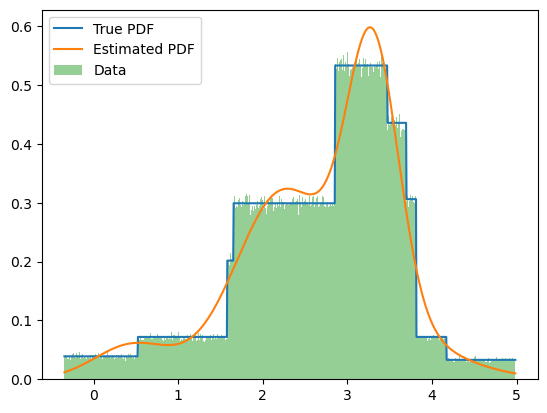

In [206]:
plt.plot(linsp, dist.p_x(linsp), label="True PDF")
plt.plot(linsp, gmm.p_x(linsp), label="Estimated PDF")
plt.hist(X, bins=1000, density=True, alpha=0.5, label="Data")
plt.legend()
plt.show()

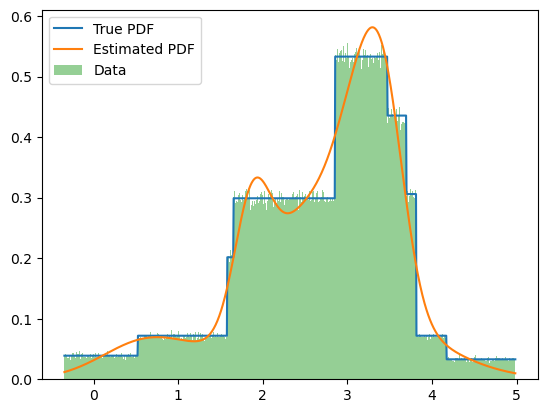

In [212]:
plt.plot(linsp, dist.p_x(linsp), label="True PDF")
plt.plot(linsp, gmm.p_x(linsp), label="Estimated PDF")
plt.hist(X, bins=1000, density=True, alpha=0.5, label="Data")
plt.legend()
plt.show()

In [253]:
class Random2DGaussian:
    """
    Random bivariate normal distribution sampler.

    Hardwired parameters:
        horizontal_min, horizontal_max: horizontal range for the mean
        vertical_min, vertical_max: vertical range for the mean
        scale: controls the covariance range

    Methods:
        __init__: creates a new distribution
        get_sample(n): samples n datapoints
    """

    horizontal_min = 0
    horizontal_max = 10
    vertical_min = 0
    vertical_max = 10
    scale = 5

    def __init__(self):
        horizontal_range, vertical_range = self.horizontal_max - self.horizontal_min, self.vertical_max - self.vertical_min
        mean = (self.horizontal_min, self.vertical_min)
        mean += np.random.random_sample(2) * (horizontal_range, vertical_range)

        # Variances for principle directions (horizontal/vertical)
        eigvals = np.random.random_sample(2)
        eigvals *= (horizontal_range / self.scale, vertical_range / self.scale)
        eigvals **= 2

        # Pick random rotation [0, 1> * 2pi = [0, 2pi>
        theta = np.random.random_sample() * np.pi * 2
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        # Covariance matrix
        Sigma = R.T @ np.diag(eigvals) @ R

        self.get_sample = lambda n: np.random.multivariate_normal(mean, Sigma, n)

# One Gaussian source per class
def sample_gauss_2d(num_classes, num_samples_per_class):
    # Create Gaussians
    Gs, ys = [], []
    for i in range(num_classes):
        Gs.append(Random2DGaussian())
        ys.append(i)

    # Sample dataset
    X = np.vstack([G.get_sample(num_samples_per_class) for G in Gs])
    y = np.hstack([[y] * num_samples_per_class for y in ys])
    return X, y

# One class can have multiple Gaussian components
def sample_gmm_2d(num_components, num_classes, num_samples_per_class):
    # Create Gaussian components and assign them random class idx
    Gs, ys = [], []
    for _ in range(num_components):
        Gs.append(Random2DGaussian())
        ys.append(np.random.randint(num_classes))

    # Sample dataset
    X = np.vstack([G.get_sample(num_samples_per_class) for G in Gs])
    y = np.hstack([[y] * num_samples_per_class for y in ys])
    return X, y

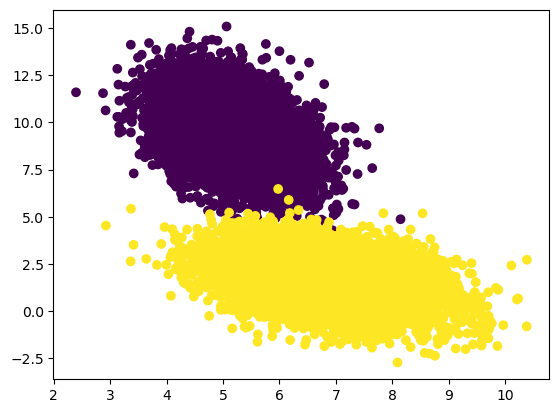

In [327]:
np.random.seed(23)
X, y = sample_gauss_2d(num_classes=2, num_samples_per_class=10000)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [323]:
class GMM:
    def __init__(self, D, K):
        self.K = K
        self.D = D
        self.pi = np.ones(K) / K
        self.mu = np.random.randn(K, D)
        self.sigma2 = np.array([np.eye(D) for _ in range(K)])

    def init_from_samples(self, x):
        indices = np.random.choice(len(x), size=self.K, replace=False)
        self.mu = x[indices]
    
    def e_step(self, x):
        N = x.shape[0]
        pdfs = np.array([
            multivariate_normal.pdf(x, mean=self.mu[k], cov=self.sigma2[k])
            for k in range(self.K)
        ]).T  # (N, K)

        weighted_pdfs = self.pi * pdfs  # (N, K)
        gamma = weighted_pdfs / np.sum(weighted_pdfs, axis=1, keepdims=True)
        return gamma

    def m_step(self, x, gamma):
        Nk = np.sum(gamma, axis=0)
        self.pi = Nk / len(x)
        self.mu = (gamma.T @ x) / Nk[:, np.newaxis]  # (K, D)

        for k in range(self.K):
            diff = x - self.mu[k]  # (N, D)
            weighted_diff = gamma[:, k][:, np.newaxis] * diff  # (N, D)
            self.sigma2[k] = (weighted_diff.T @ diff) / Nk[k]  # (D, D)
            self.sigma2[k] += 1e-6 * np.eye(self.D)  # Avoid zeros on diagonal

    def log_likelihood(self, x):
        pdfs = np.array([
            multivariate_normal.pdf(x, mean=self.mu[k], cov=self.sigma2[k])
            for k in range(self.K)
        ]).T  # (N, K)

        total_prob = np.sum(self.pi * pdfs, axis=1)  # (N,)
        log_total_prob = np.log(total_prob + 1e-10)
        log_likelihood = np.mean(log_total_prob)  # Avoid log(0)
        return log_likelihood

    def p_xz(self, x, k):
        return multivariate_normal.pdf(x, mean=self.mu[k], cov=self.sigma2[k])
        
    def p_x(self, x):
        pdfs = np.array([
            multivariate_normal.pdf(x, mean=self.mu[k], cov=self.sigma2[k])
            for k in range(self.K)
        ]).T  # (N, K)

        return np.sum(self.pi * pdfs, axis=1)  # (N,)


In [346]:
np.random.seed(5)
gmm = GMM(D=2, K=1)
for i in range(100):
    gamma = gmm.e_step(X)
    gmm.m_step(X, gamma)
    ll = gmm.log_likelihood(X)
    # print(f"Epoch: {i}, LL: {ll:.3f}")

In [336]:
def plot_gmm_with_data(gmm, X, y=None):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Subplot 1: Original data points with true values (if y is provided)
    ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10, alpha=0.7)
    ax[0].set_title("Data Points with True Labels")
    ax[0].set_xlabel("X1")
    ax[0].set_ylabel("X2")
    
    # Subplot 2: Cluster assignments from GMM
    gamma = gmm.e_step(X)  # Responsibilities
    cluster_assignments = np.argmax(gamma, axis=1)
    ax[1].scatter(X[:, 0], X[:, 1], c=cluster_assignments, cmap='tab10', s=10, alpha=0.7)
    ax[1].set_title("GMM Cluster Assignments")
    ax[1].set_xlabel("X1")
    ax[1].set_ylabel("X2")
    
    # Overlay GMM component ellipses on Subplot 2
    for k in range(gmm.K):
        plot_ellipse(ax[1], gmm.mu[k], gmm.sigma2[k], color='red')
    
    plt.tight_layout()
    plt.show()

def plot_ellipse(ax, mean, cov, color, n_std=2.0):
    """Plot an ellipse representing a Gaussian component."""
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, fc='none', lw=2)
    ax.add_patch(ellipse)

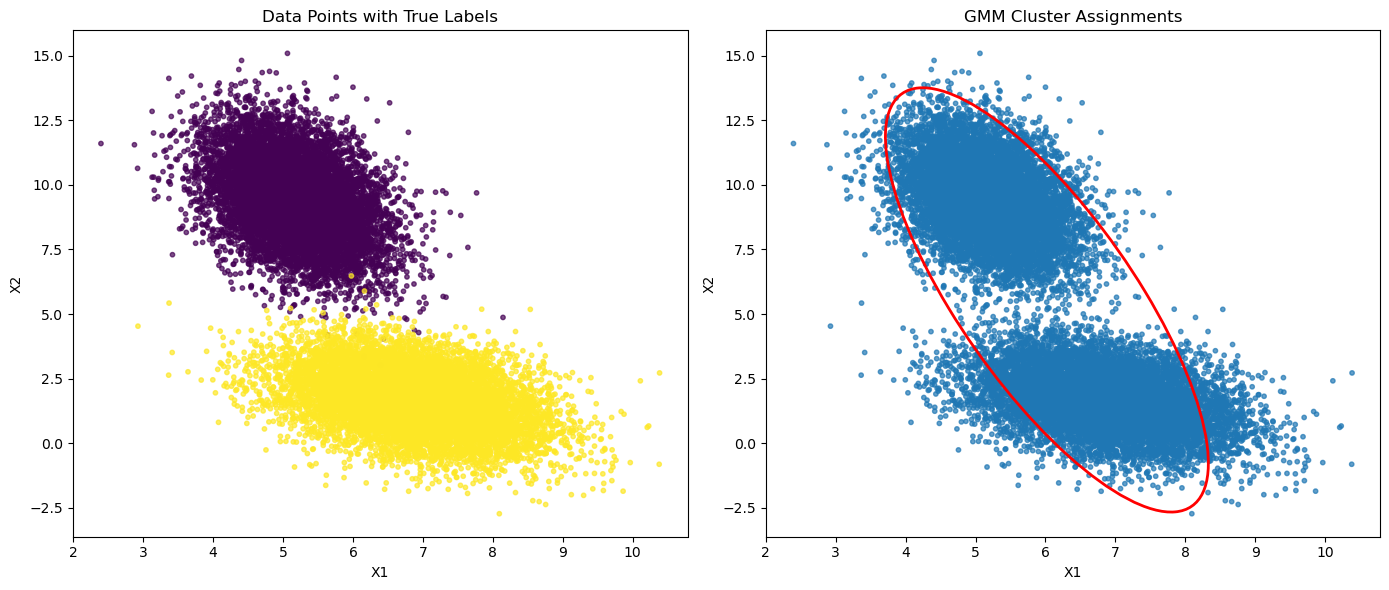

In [347]:
plot_gmm_with_data(gmm, X, y)